In [13]:
import numpy as np
%matplotlib inline

import torch
import torch.optim as optim

from dataset import get_set_loaders, imshow
from capsulenet import CapsNet

In [7]:
torch.set_num_threads(12)

In [8]:
train_set_loader, test_set_loader = get_set_loaders()

# Train

### Init model

In [9]:
USE_CUDA = True
EPOCHS = 30

if USE_CUDA and torch.cuda.is_available():
    print('USING CUDA')
    device = torch.device('cuda')
else:
    print('USING CPU')
    device = torch.device('cpu')

capsnet = CapsNet(cuda=USE_CUDA)
capsnet = capsnet.to(device)


USING CPU


### Optimizer

In [10]:
optimizer = optim.Adam(capsnet.parameters(), lr=0.001)

### Train loop

In [12]:
for epoch in range(1, EPOCHS+1):
    
    print()
    print('='*10, 'TRAIN', '='*10)
    capsnet.train()
    running_loss = 0.0
    running_accuracy = 0.0
    
    for i, batch in enumerate(train_set_loader, 1):        
        # Load the batch
        images, targets = batch
        images = images.to(device)
        targets = targets.to(device)
        
        # Zero grad
        optimizer.zero_grad()
        # Forward
        output, norm, reconstruction = capsnet(images, targets)
        # Compute loss
        loss = CapsNet.loss(norm, targets, reconstruction, images)
        # Compute accuracy
        most_active_idx = norm.argmax(dim=1)
        accuracy = torch.sum((most_active_idx == targets)).item() / targets.size(0)
        # Backward
        loss.backward()
        # Optim step
        optimizer.step()
        
        # Add loss
        running_loss += loss.item()
        # Add accuracy
        running_accuracy += accuracy
        
        if i % 100 == 0:
            print(f'==> EPOCH[{epoch}]({i}/{len(train_set_loader)}): LOSS: {loss.item()} ACCURACY: {accuracy}')
            
    print(f'=====> EPOCH[{epoch}] Completed: Avg. LOSS: {running_loss/len(train_set_loader)} Avg. ACCURACY {running_accuracy/len(train_set_loader)}')
    
    print()
    print('='*10, 'EVAL', '='*10)
    capsnet.eval()
    running_accuracy = 0.0
    
    for i, batch in enumerate(test_set_loader, 1):

        # Load the batch
        images, targets = batch
        images = images.to(device)
        targets = targets.to(device)
        
        with torch.no_grad():
            # Forward
            output, norm, reconstruction = capsnet(images)
            most_active_idx = norm.argmax(dim=1)
            running_accuracy += torch.sum((most_active_idx == targets)).item() / targets.size(0)

    print(f'=====> EPOCH[{epoch}]: AVG. ACCURACY: {running_accuracy/len(test_set_loader)}')


========== TRAIN ==========


Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 242

KeyboardInterrupt: 

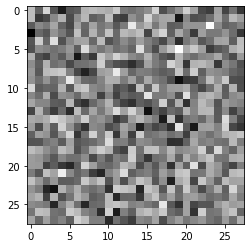

In [14]:
imshow(reconstruction[0].detach().view(28, 28).numpy())